In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
from zipfile import ZipFile
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow 
import cv2
import glob
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Kaggle api 
# for dogs
!kaggle competitions download -c dogs-vs-cats

# for cars
!kaggle datasets download -d jessicali9530/stanford-cars-dataset

 99% 806M/812M [00:06<00:00, 31.9MB/s]
100% 812M/812M [00:07<00:00, 122MB/s] 
 99% 1.80G/1.82G [00:19<00:00, 99.6MB/s]
100% 1.82G/1.82G [00:19<00:00, 98.3MB/s]


In [ ]:
# extract all datasets
dogs_vs_cats_dataset = '/content/dogs-vs-cats.zip'
cars_dataset = '/content/stanford-cars-dataset.zip'

with ZipFile(dogs_vs_cats_dataset, 'r') as zip:
  zip.extractall()
  print('The cats and dogs dataset is extracted')


with ZipFile(cars_dataset, 'r') as zip:
  zip.extractall()
  print('The cars dataset is extracted')

The cats and dogs dataset is extracted
The cars dataset is extracted


In [ ]:
# extract train dataset
dogs_vs_cats_train_dataset = '/content/train.zip'

with ZipFile(dogs_vs_cats_train_dataset, 'r') as zip:
  zip.extractall()
  print('The cats and dog train dataset is extracted')

The cats and dog train dataset is extracted


In [ ]:
# counting the number of files in train folder(cats + dogs)
dogs_vs_cats_path, dogs_vs_cats_dirs, dogs_vs_cats_files = next(os.walk('/content/train'))

print('Number of images(dogs + cats): ', len(dogs_vs_cats_files))

Number of images(dogs + cats):  25000


In [ ]:
# select only dogs
dog_files = []
for i in dogs_vs_cats_files:
  if i[0:3] == 'dog':
    dog_files.append(i)

print('Number of images(only dogs): ', len(dog_files))

Number of images(only dogs):  12500


In [ ]:
# counting the number of files in train folder(cats + dogs)
car_path, car_dirs, car_files = next(os.walk('/content/cars_train/cars_train'))
print('Number of images: ', len(car_files))

Number of images:  8144


In [ ]:
# display image
def display_image(img_path):
  img = mpimg.imread(img_path)
  imgplt = plt.imshow(img)
  plt.show()

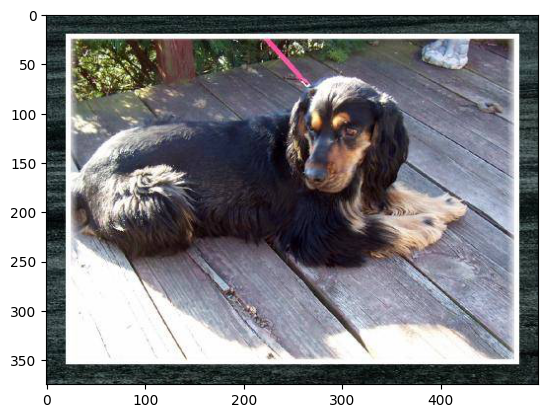

In [ ]:
display_image('/content/train/'+dog_files[11])

In [ ]:
 os.mkdir('/content/image-resized-cars-vs-dogs')

In [ ]:
original_folder_dogs = '/content/train/'
original_folder_cars = '/content/cars_train/cars_train/'
resized_folder = '/content/image-resized-cars-vs-dogs/'

for i in range(2000):

  img_path_to_dogs = original_folder_dogs + dog_files[i]
  img_path_to_cars = original_folder_cars + car_files[i]

  dog_img = Image.open(img_path_to_dogs)
  dog_img = dog_img.resize((224, 224))
  dog_img = dog_img.convert('RGB')

  car_img = Image.open(img_path_to_cars)
  car_img = car_img.resize((224, 224))
  car_img = car_img.convert('RGB')

  newImgPath_dogs = resized_folder + dog_files[i]
  newImgPath_cars = resized_folder + car_files[i]

  dog_img.save(newImgPath_dogs)
  car_img.save(newImgPath_cars)

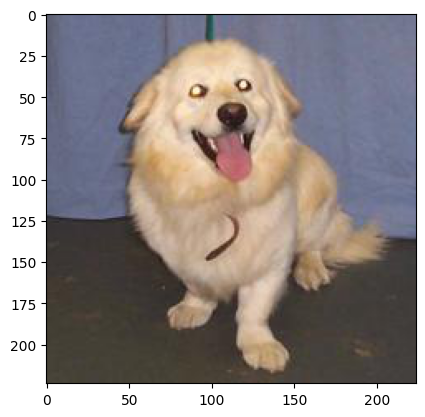

In [ ]:
display_image('/content/image-resized-cars-vs-dogs/'+dog_files[12])

In [ ]:
# Creating labels for resized images of cars and dogs
# Car --> 0
# Dog --> 1

# creaing a for loop to assign labels
filenames = os.listdir('/content/image-resized-cars-vs-dogs/')

labels = []

for i in range(len(filenames)):

  file_name = filenames[i]
  label = file_name[0:3]

  if label == 'dog':
    labels.append(1)

  else:
    labels.append(0)

In [ ]:
print(filenames[0:5])
print(labels[0:5])
print('Number of images: ' + str(len(filenames)))
print('Number of labels: ' + str(len(labels)))

['dog.9768.jpg', '01178.jpg', 'dog.230.jpg', '05810.jpg', '00038.jpg']
[1, 0, 1, 0, 0]
Number of images: 4000
Number of labels: 4000


In [ ]:
# counting the images of dogs and cats out of 2000 images
values, counts = np.unique(labels, return_counts=True)
print(values)
print(counts)

[0 1]
[2000 2000]


In [ ]:
image_extension = ['png', 'jpg']

files = []

[files.extend(glob.glob('/content/image-resized-cars-vs-dogs/*.' + e)) for e in image_extension]

cars_vs_dogs_images = np.asarray([cv2.imread(file) for file in files])

In [ ]:
X = cars_vs_dogs_images
Y = np.asarray(labels)

In [ ]:
# 3200 --> training images
# 800 --> test images

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
print(X.shape, X_train.shape, X_test.shape)

(4000, 224, 224, 3) (3200, 224, 224, 3) (800, 224, 224, 3)


In [ ]:
# scaling the data
X_train_scaled = X_train/255

X_test_scaled = X_test/255

In [ ]:
mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

pretrained_model = hub.KerasLayer(mobilenet_model, input_shape=(224,224,3), trainable=False)

In [ ]:
num_of_classes = 2

model = tf.keras.Sequential([
    
    pretrained_model,
    tf.keras.layers.Dense(num_of_classes)

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['acc']
)

In [ ]:
model.fit(X_train_scaled, Y_train, epochs=5)

Epoch 1/5
100/100 [==============================] - 78s 734ms/step - loss: 0.0543 - acc: 0.9850
Epoch 2/5
100/100 [==============================] - 70s 698ms/step - loss: 0.0055 - acc: 0.9994
Epoch 3/5
100/100 [==============================] - 70s 700ms/step - loss: 0.0030 - acc: 1.0000
Epoch 4/5
100/100 [==============================] - 73s 729ms/step - loss: 0.0018 - acc: 1.0000
Epoch 5/5
100/100 [==============================] - 70s 698ms/step - loss: 0.0013 - acc: 1.0000


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MobileNetModel/model.h5')

NameError: ignored

In [ ]:
from tensorflow.keras.models import load_model
# model =load_model('/content/drive/MyDrive/Colab Notebooks/MobileNetModel/model.h5')

model = tf.keras.models.load_model(
       ('/content/drive/MyDrive/Colab Notebooks/MobileNetModel/model.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [ ]:
score, acc = model.evaluate(X_test_scaled, Y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

25/25 [==============================] - 18s 693ms/step - loss: 0.0011 - acc: 1.0000
Test Loss = 0.0011195524130016565
Test Accuracy = 1.0


In [ ]:
def predict_image(img_path):

  input_image = cv2.imread(img_path)

  cv2_imshow(input_image)

  input_image_resize = cv2.resize(input_image, (224,224))

  input_image_scaled = input_image_resize/255

  image_reshaped = np.reshape(input_image_scaled, [1,224,224,3])

  input_prediction = model.predict(image_reshaped)

  print(input_prediction)

  input_pred_label = np.argmax(input_prediction)

  print(input_pred_label)

  if input_pred_label == 0:
    print('The image represents a Car')

  else:
    print('The image represents a Dog')

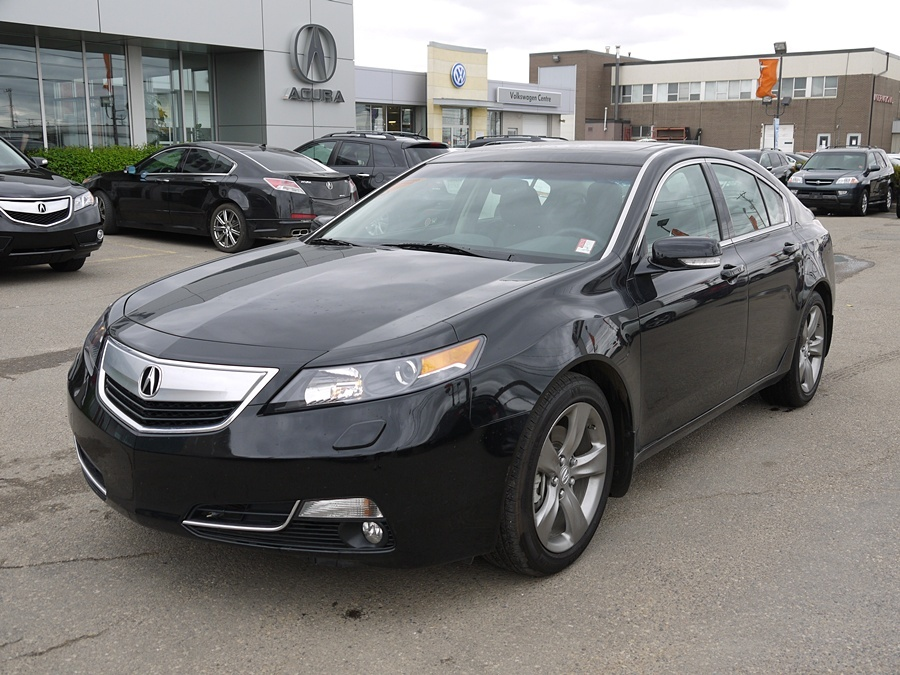

1/1 [==============================] - 0s 402ms/step
[[ 3.8866699 -3.6843503]]
0
The image represents a Car


In [ ]:
predict_image('/content/cars_train/cars_train/00002.jpg')

In [ ]:
!pip uninstall shap

Found existing installation: shap 0.41.0
Uninstalling shap-0.41.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/shap-0.41.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/shap/*
Proceed (Y/n)? y
  Successfully uninstalled shap-0.41.0


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached shap-0.41.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (572 kB)


In [ ]:
import shap

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import json
# import shap
import tensorflow as tf

def f(X):
    tmp = X.copy()
    # preprocess_input(tmp)
    tmp = tmp/255
    return model(tmp)

class_names=['car', 'dog']
# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X[0].shape)
masker1 = shap.maskers.Image("blur(128,128)", X[0].shape)
# masker1 = shap.maskers.Image("blur(128,128)", X[0].shape)
# blur(128,128)
# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(f, masker1, output_names=class_names)

# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[0:2], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:2])

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 3it [04:02, 121.13s/it]


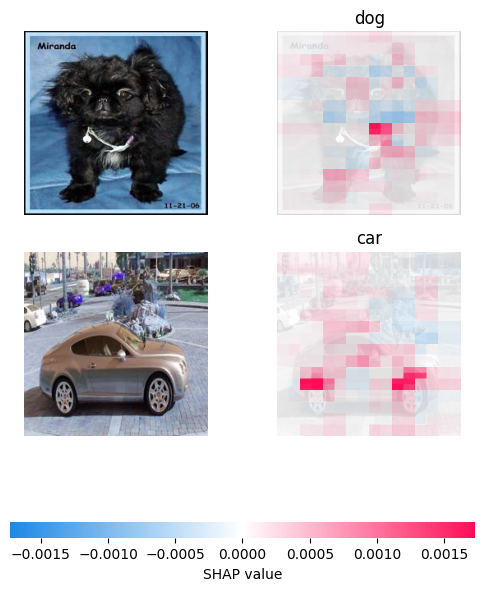

In [ ]:
shap.image_plot(shap_values)

In [ ]:
shap_values = explainer(X[0:7], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])

  0%|          | 0/4998 [00:00<?, ?it/s]


Partition explainer:  14%|█▍        | 1/7 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]


Partition explainer:  43%|████▎     | 3/7 [04:12<04:14, 63.57s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]


Partition explainer:  57%|█████▋    | 4/7 [06:18<04:29, 89.93s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]


Partition explainer:  71%|███████▏  | 5/7 [08:26<03:28, 104.02s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]


Partition explainer:  86%|████████▌ | 6/7 [10:34<01:52, 112.35s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]


Partition explainer: 100%|██████████| 7/7 [12:50<00:00, 120.30s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]


Partition explainer: 8it [15:02, 128.97s/it]


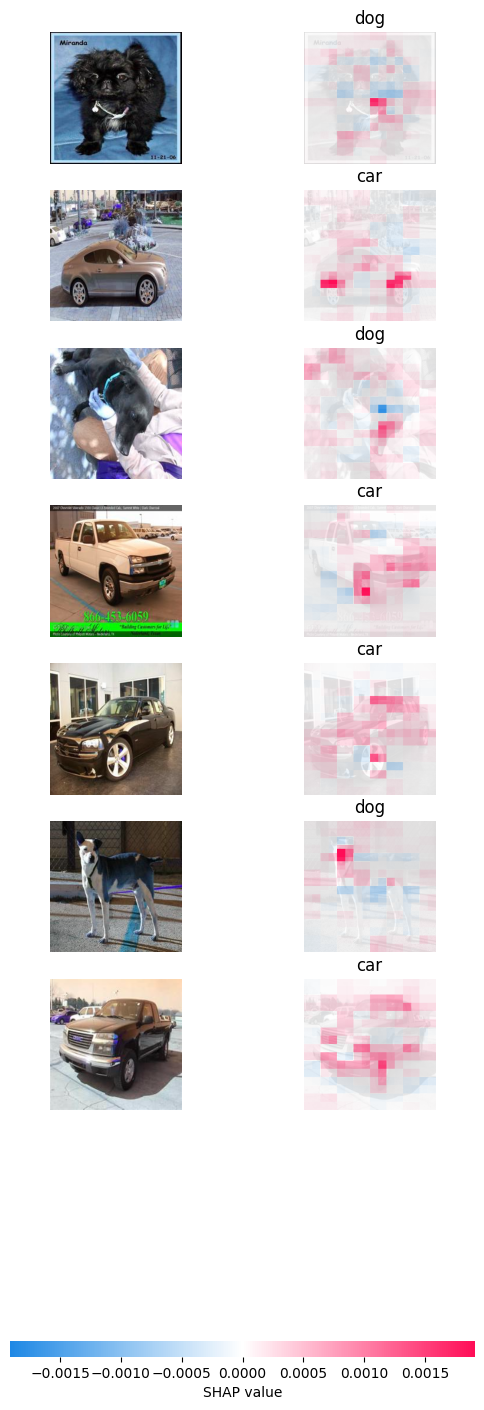

In [ ]:
shap.image_plot(shap_values)

In [ ]:
pred = model(X[0:5])

print(pred)
for i in range(5):
  print(np.argmax(pred[i]))

tf.Tensor(
[[-2.1519518  -0.08790911]
 [-3.1921132   0.4726824 ]
 [-3.4604068   0.44046533]
 [-3.1447213   1.7671143 ]
 [-3.4233124   0.9960517 ]], shape=(5, 2), dtype=float32)
1
1
1
1
1


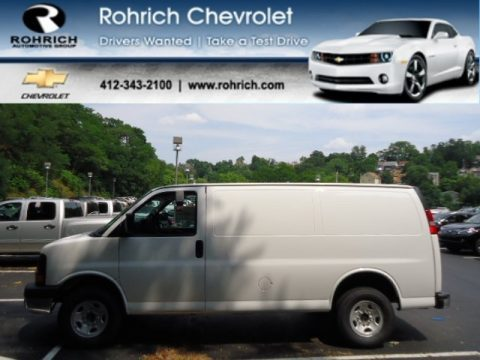

1/1 [==============================] - 0s 48ms/step
[[ 4.5267477 -3.841092 ]]
0
The image represents a Car


In [ ]:
predict_image('/content/cars_train/cars_train/00100.jpg')

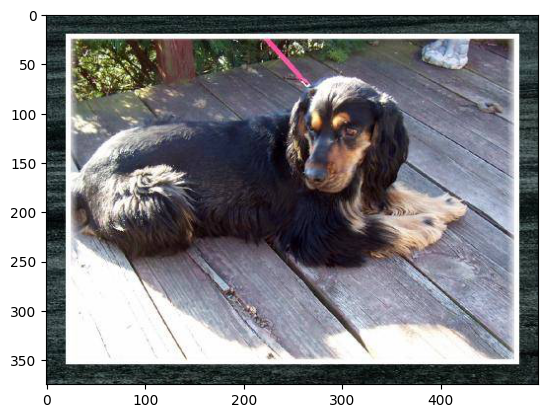

In [ ]:
display_image('/content/train/'+dog_files[11])

In [ ]:
print(len(X))

4000


In [ ]:
# load the model
# model = models.vgg16(pretrained=True).eval()

# X,y = shap.datasets.imagenet50()

# X /= 255

to_explain = X_train_scaled[[39, 41]]

# load the ImageNet class names
# url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
# fname = shap.datasets.cache(url)
# with open(fname) as f:
#     class_names = json.load(f)

e = shap.GradientExplainer(model, f(X))
shap_values,indexes = e.shap_values(f(to_explain), ranked_outputs=2, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)